In [1]:
import pprint
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
pd.set_option( 'display.max_columns', 10 )
pd.set_option('precision', 6)
pd.set_option('max_colwidth', 20)
pd.set_option('display.width', 120)

path = 'C:\\Users\\sophia.yue\\Data\\'
df = pd.read_csv(path + 'bank-full.csv', sep=';')
df.head()
df.shape
df.describe()
df.info()
#  Examine target values and map to 0 and 1
df.y.value_counts()             
targ_dict = {'no': 0, 'yes':1 }
df['target'] = [targ_dict[yy] for yy in df.y]
df.target.value_counts()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


0    39922
1     5289
Name: target, dtype: int64

In [3]:
df.dtypes[df.dtypes == 'O']

job          object
marital      object
education    object
default      object
housing      object
loan         object
contact      object
month        object
poutcome     object
y            object
dtype: object

In [4]:
df.dtypes[df.dtypes != 'O']

age         int64
balance     int64
day         int64
duration    int64
campaign    int64
pdays       int64
previous    int64
target      int64
dtype: object

In [5]:
df.head()

,age,job,marital,education,default,...,pdays,previous,poutcome,y,target
0,58,management,married,tertiary,no,...,-1,0,unknown,no,0
1,44,technician,single,secondary,no,...,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,...,-1,0,unknown,no,0
3,47,blue-collar,married,unknown,no,...,-1,0,unknown,no,0
4,33,unknown,single,unknown,no,...,-1,0,unknown,no,0


## function infValueEquibin

In [6]:
def infValueEquibin( x, y, n=7, labels=(0,1), names=('Neg', 'Pos'), mins=(1,1), verb=False):

    #n = np.min([np.max([n,3]),7])
    
    xx = pd.qcut( x, n, duplicates='drop')    
    a = pd.crosstab( xx, y ) 
    a = a.sort_index( 0 )     #  To ensure ascending order
    labs2keep=[g for g in a.columns if g in labels ]
    a = a[labs2keep]
    a.columns = names

    ''' 
	 From this point on merely repeats the code in infValue
	 We can either call infValue with 'xx' instead of 'x'
	 But a better aproach is to consolidate the below code into core functionality
	 That leaves the door open to extend it to compute Mututal information.
	 That code will not need to know anything about how the grouping is done, which is perfect!
    '''

    #  Create column containing Column Percentages
    pct_cols = ['Pct_'+ b for b in a.columns]
    for i in range(len(a.columns)):
        a[pct_cols[i]]=a[a.columns[i]]/sum(a[a.columns[i]])
    
	#  The below line should be a loop to handle any number of class labels
    a['use']       = np.where( np.logical_and( a[a.columns[0]] > mins[0], a[a.columns[1]] > mins[1]), 1, 0)
    a['woe']       = np.where( a['use'] == 1, np.log(a[a.columns[len(names)]]/a[a.columns[len(names)+1]]), 0)
    a['ivcontrib'] = (a[a.columns[len(names)]]-a[a.columns[len(names)+1]]) * a['woe' ]
  
    inf_val = sum( a['ivcontrib'] )
    
    if verb:
        print('Inf. value = '+ str(inf_val) + ', '+ str(sum(a['use'])) + ' of '+str(len(a['use'])) + ' levels contributing')
        print(a)
        
    return (inf_val, a)

In [7]:
#  Information Value -- Numerical fields
(iv5, a5) = infValueEquibin( df['duration'], df['target'], n=12, verb=True, mins=(500,100), names=('No_Deposit','Deposit') )
(iv6, a6) = infValueEquibin( df['campaign'], df['target'], n=10, verb=True, mins=(500,100), names=('No_Deposit','Deposit') )
(iv7, a7) = infValueEquibin( df['pdays'],    df['target'], n=12, verb=True, mins=(500,100), names=('No_Deposit','Deposit') )
(iv8, a8) = infValueEquibin( df['age'],      df['target'], n=12, verb=True, mins=(500,100), names=('No_Deposit','Deposit') )

ivdict2 = {'duration': iv5, 'campaign': iv6, 'pdays': iv7, 'age': iv8}
pprint.pprint(ivdict2)

Inf. value = 0.8528696434614229, 9 of 12 levels contributing
                 No_Deposit  Deposit  Pct_No_Deposit  Pct_Deposit  use       woe  ivcontrib
duration                                                                                   
(-0.001, 52.0]         3818        9        0.095636     0.001702    0  0.000000   0.000000
(52.0, 80.0]           3812       30        0.095486     0.005672    0  0.000000   0.000000
(80.0, 103.0]          3618       88        0.090627     0.016638    0  0.000000   0.000000
(103.0, 126.0]         3583      118        0.089750     0.022310    1  1.391973   0.093874
(126.0, 152.0]         3629      201        0.090902     0.038003    1  0.872109   0.046134
(152.0, 180.0]         3491      263        0.087446     0.049726    1  0.564491   0.021292
(180.0, 215.0]         3435      334        0.086043     0.063150    1  0.309333   0.007082
(215.0, 258.0]         3331      419        0.083438     0.079221    1  0.051859   0.000219
(258.0, 319.0]     

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


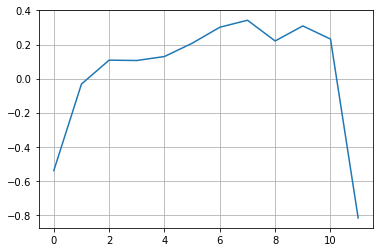

In [8]:
import seaborn as sns
plt.plot( a8.woe); plt.grid()
#a8.index

In [23]:
a8.head()

,No_Deposit,Deposit,Pct_No_Deposit,Pct_Deposit,use,woe,ivcontrib
age,,,,,,,
"(17.999, 28.0]",3331,757,0.083438,0.143127,1,-0.539634,0.032210
"(28.0, 31.0]",4344,594,0.108812,0.112309,1,-0.031627,0.000111
"(31.0, 33.0]",3626,431,0.090827,0.081490,1,0.108479,0.001013
"(33.0, 35.0]",3417,407,0.085592,0.076952,1,0.106407,0.000919
"(35.0, 37.0]",3137,365,0.078578,0.069011,1,0.129826,0.001242


array([<AxesSubplot:xlabel='age'>, <AxesSubplot:xlabel='age'>,
       <AxesSubplot:xlabel='age'>, <AxesSubplot:xlabel='age'>,
       <AxesSubplot:xlabel='age'>, <AxesSubplot:xlabel='age'>,
       <AxesSubplot:xlabel='age'>], dtype=object)

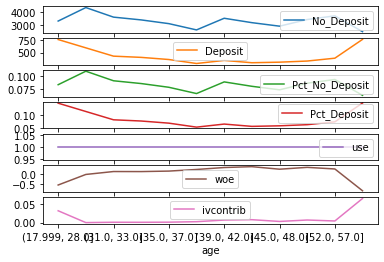

In [22]:
a8.plot.line(subplots=True)

<AxesSubplot:xlabel='age'>

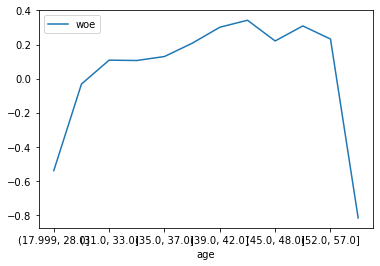

In [28]:
a8[['woe']].plot.line()

<AxesSubplot:xlabel='age'>

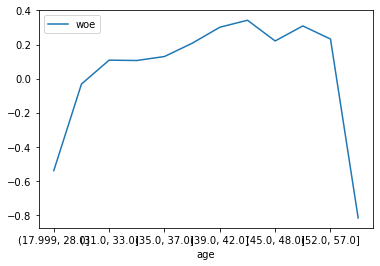

In [27]:
a8[['woe']].plot.line(rot = 0)

In [ ]:
a8[['woe']].plot.line()

<AxesSubplot:xlabel='age'>

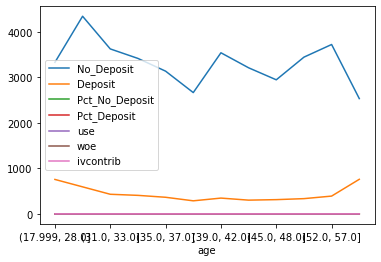

In [24]:
a8.plot.line()

In [ ]:
a8.hist(figsize = (14, 14))

In [ ]:
df = pd.DataFrame({
   'pig': [20, 18, 489, 675, 1776],
   'horse': [4, 25, 281, 600, 1900]
   }, index=[1990, 1997, 2003, 2009, 2014])
lines = df.plot.line()

array([[<AxesSubplot:title={'center':'No_Deposit'}>,
        <AxesSubplot:title={'center':'Deposit'}>,
        <AxesSubplot:title={'center':'Pct_No_Deposit'}>],
       [<AxesSubplot:title={'center':'Pct_Deposit'}>,
        <AxesSubplot:title={'center':'use'}>,
        <AxesSubplot:title={'center':'woe'}>],
       [<AxesSubplot:title={'center':'ivcontrib'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

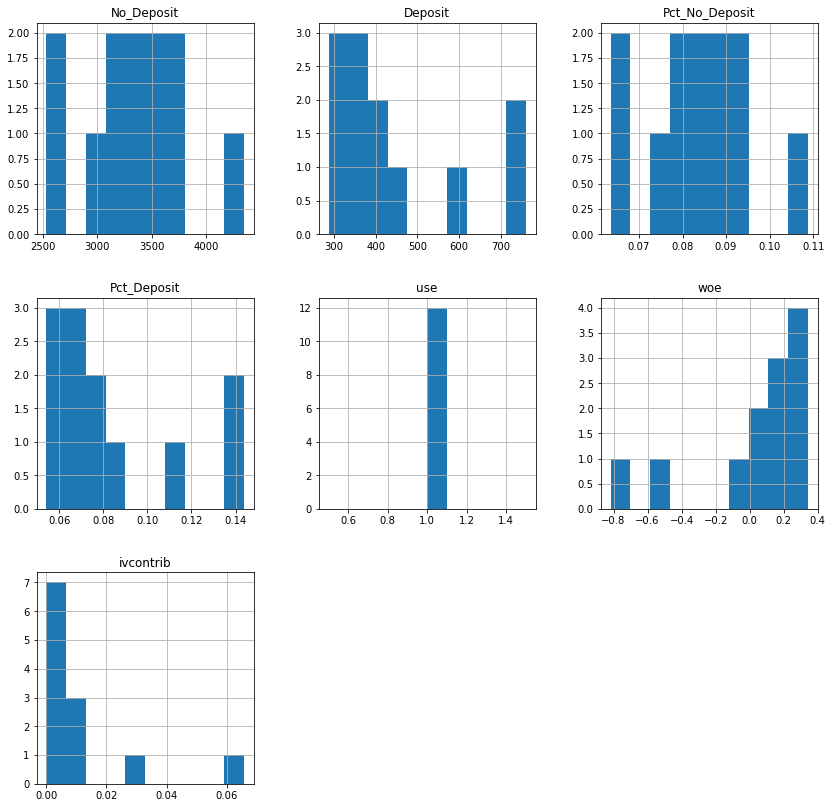

In [26]:
a8.hist(figsize = (14, 14))

In [21]:
a8.plot.line(x = a8.index, y = 'age')

KeyError: "None of [CategoricalIndex([(17.999, 28.0],   (28.0, 31.0],   (31.0, 33.0],   (33.0, 35.0],   (35.0, 37.0],   (37.0, 39.0],\n                    (39.0, 42.0],   (42.0, 45.0],   (45.0, 48.0],   (48.0, 52.0],   (52.0, 57.0],   (57.0, 95.0]],\n                 categories=[(17.999, 28.0], (28.0, 31.0], (31.0, 33.0], (33.0, 35.0], (35.0, 37.0], (37.0, 39.0], (39.0, 42.0], (42.0, 45.0], ...], ordered=True, name='age', dtype='category')] are in the [columns]"

In [20]:
a8.plot.line(x = a8.index, y = 'woe')

KeyError: "None of [CategoricalIndex([(17.999, 28.0],   (28.0, 31.0],   (31.0, 33.0],   (33.0, 35.0],   (35.0, 37.0],   (37.0, 39.0],\n                    (39.0, 42.0],   (42.0, 45.0],   (45.0, 48.0],   (48.0, 52.0],   (52.0, 57.0],   (57.0, 95.0]],\n                 categories=[(17.999, 28.0], (28.0, 31.0], (31.0, 33.0], (33.0, 35.0], (35.0, 37.0], (37.0, 39.0], (39.0, 42.0], (42.0, 45.0], ...], ordered=True, name='age', dtype='category')] are in the [columns]"

In [9]:
## simulation infValueEquibin

In [10]:
    n=12; labels=(0,1); names=('No_Deposit','Deposit') ; mins=(500,100); verb=False 
    x  = df['duration']; y =df['target']
    xx = pd.qcut( x, n, duplicates='drop')    # pandas.core.series.Series

In [11]:
xx

0         (258.0, 319.0]
1         (126.0, 152.0]
2           (52.0, 80.0]
3          (80.0, 103.0]
4         (180.0, 215.0]
              ...       
45206    (603.0, 4918.0]
45207     (411.0, 603.0]
45208    (603.0, 4918.0]
45209     (411.0, 603.0]
45210     (319.0, 411.0]
Name: duration, Length: 45211, dtype: category
Categories (12, interval[float64]): [(-0.001, 52.0] < (52.0, 80.0] < (80.0, 103.0] < (103.0, 126.0] ... (258.0, 319.0] < (319.0, 411.0] < (411.0, 603.0] < (603.0, 4918.0]]

In [12]:
xx.value_counts()  # get counts of y

(52.0, 80.0]       3842
(126.0, 152.0]     3830
(-0.001, 52.0]     3827
(258.0, 319.0]     3771
(180.0, 215.0]     3769
(603.0, 4918.0]    3757
(152.0, 180.0]     3754
(319.0, 411.0]     3752
(411.0, 603.0]     3752
(215.0, 258.0]     3750
(80.0, 103.0]      3706
(103.0, 126.0]     3701
Name: duration, dtype: int64

In [13]:

df1 = df.copy()
df1['duration_gp'] = pd.qcut(df1['duration'], 3)
df1.head()

,age,job,marital,education,default,...,previous,poutcome,y,target,duration_gp
0,58,management,married,tertiary,no,...,0,unknown,no,0,"(258.0, 4918.0]"
1,44,technician,single,secondary,no,...,0,unknown,no,0,"(126.0, 258.0]"
2,33,entrepreneur,married,secondary,no,...,0,unknown,no,0,"(-0.001, 126.0]"
3,47,blue-collar,married,unknown,no,...,0,unknown,no,0,"(-0.001, 126.0]"
4,33,unknown,single,unknown,no,...,0,unknown,no,0,"(126.0, 258.0]"


In [14]:
df1[['duration', 'duration_gp']].head()

,duration,duration_gp
0,261,"(258.0, 4918.0]"
1,151,"(126.0, 258.0]"
2,76,"(-0.001, 126.0]"
3,92,"(-0.001, 126.0]"
4,198,"(126.0, 258.0]"


In [15]:
    xx = pd.qcut( x, n, duplicates='drop')    
    a = pd.crosstab( xx, y )
    a

target,0,1
duration,,
"(-0.001, 52.0]",3818,9
"(52.0, 80.0]",3812,30
"(80.0, 103.0]",3618,88
"(103.0, 126.0]",3583,118
"(126.0, 152.0]",3629,201
"(152.0, 180.0]",3491,263
"(180.0, 215.0]",3435,334
"(215.0, 258.0]",3331,419
"(258.0, 319.0]",3259,512


In [16]:
 a = a.sort_index( 0 ) 
 a   

target,0,1
duration,,
"(-0.001, 52.0]",3818,9
"(52.0, 80.0]",3812,30
"(80.0, 103.0]",3618,88
"(103.0, 126.0]",3583,118
"(126.0, 152.0]",3629,201
"(152.0, 180.0]",3491,263
"(180.0, 215.0]",3435,334
"(215.0, 258.0]",3331,419
"(258.0, 319.0]",3259,512


In [17]:
#def infValueEquibin( x, y, n=7, labels=(0,1), names=('Neg', 'Pos'), mins=(1,1), verb=False):

    
    xx = pd.qcut( x, n, duplicates='drop')    
    a = pd.crosstab( xx, y ) 
    a = a.sort_index( 0 )     #  To ensure ascending order
    labs2keep=[g for g in a.columns if g in labels ]
    a = a[labs2keep]
    a.columns = names

    #n = np.min([np.max([n,3]),7])
    
    xx = pd.qcut( x, n, duplicates='drop')    
    a = pd.crosstab( xx, y ) 
    a = a.sort_index( 0 )     #  To ensure ascending order
    labs2keep=[g for g in a.columns if g in labels ]
    a = a[labs2keep]
    a.columns = names

IndentationError: unexpected indent (<ipython-input-17-fffc923472a1>, line 4)